In [1]:
import numpy as np
import matplotlib.pyplot as plt
import boost_histogram as bh
import tensorflow as tf
import sklearn as sk
import pandas as pd
import pyarrow.feather as feather
import sklearn.model_selection as model_selection
import os

class DataLoader:
    def __init__(self, file_name, selected_labels):
        self.file_name = file_name
        self.selected_labels = selected_labels
        self.x_data, self.y_data, self.weight_data = self.import_feather()

    def import_feather(self):
        df = feather.read_feather(self.file_name)
        df = df.set_index(['entry', 'subentry'])
    
        initial_weight_data = df['Event.Weight'][:,0].values.reshape(-1, 1)
        weight_data = np.vstack([initial_weight_data, initial_weight_data])
        y_data = np.array(weight_data)
        y_data = (y_data > 0).astype(int)
    
        feature_columns = df.columns.intersection(self.selected_labels).tolist()
        selected_df = df[feature_columns].copy()
        selected_df = (selected_df.assign(counter=selected_df.groupby('entry').cumcount())
                       .pivot_table(index='entry', columns=['subentry'], values=feature_columns, dropna=False, fill_value=0))
    
        Pflipped_df = df.copy()
        
        flip_mask = Pflipped_df.columns.str.contains(r'\.PT|\.Eta')
        phi_mask = Pflipped_df.columns.str.contains(r'\.Phi')
        Pflipped_df.loc[:, flip_mask] *= -1 
        Pflipped_df.loc[:, phi_mask] += np.pi  
    
        plus_overflow_mask = Pflipped_df.loc[:, phi_mask] > np.pi
        minus_overflow_mask = Pflipped_df.loc[:, phi_mask] < -np.pi
    
        Pflipped_df.loc[:, phi_mask] = (Pflipped_df.loc[:, phi_mask] - 2 * np.pi * plus_overflow_mask).astype(np.float32)
        Pflipped_df.loc[:, phi_mask] = (Pflipped_df.loc[:, phi_mask] + 2 * np.pi * minus_overflow_mask).astype(np.float32)
    
        Pflipped_df = (Pflipped_df.assign(counter=Pflipped_df.groupby('entry').cumcount())
                       .pivot_table(index='entry', columns=['subentry'], values=feature_columns, dropna=False, fill_value=0))
        
        x_data = np.concatenate([selected_df.to_numpy(), Pflipped_df.to_numpy()], axis=0)
    
        #plot_kinematic_variable(selected_df, Pflipped_df, initial_weight_data, 'Electron.Eta', 'WWW')
        #plot_kinematic_variable(selected_df, Pflipped_df, initial_weight_data, 'Electron.Phi', 'WWW')
    
        print('x_data, y_data, weight_data', x_data.shape, y_data.shape, weight_data.shape)
        return x_data, y_data, weight_data

class CustomKerasClassifier(sk.base.BaseEstimator, sk.base.ClassifierMixin):
    fit_count = 0 
    total_fits = 1

    def __init__(self, input_shape, learning_rate=0.001, neurons=16, layers=2, reg_strength=0.001, epochs=50, patience=2, dropout_rate=0, batch_size=128):
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.neurons = neurons
        self.layers = layers
        self.reg_strength = reg_strength
        self.epochs = epochs
        self.patience = patience
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.model = None

    def build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.Input(shape=(self.input_shape,)))

        for _ in range(self.layers-1):
            model.add(tf.keras.layers.Dense(self.neurons, activation='relu'))

        model.add(tf.keras.layers.Dense(self.neurons, kernel_regularizer=tf.keras.regularizers.l2(self.reg_strength)))
        model.add(tf.keras.layers.Dropout(rate=self.dropout_rate))
        model.add(tf.keras.layers.Dense(2, activation='softmax'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, x_train, y_train, validation_data=(None, None)):
        CustomKerasClassifier.fit_count += 1
        #print("\n" f"Running fit {CustomKerasClassifier.fit_count}/{CustomKerasClassifier.total_fits}")

        self.model = self.build_model()
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=self.patience, restore_best_weights=True
        )

        history = self.model.fit(
            x_train, y_train, 
            validation_data=validation_data,  
            epochs=self.epochs, 
            batch_size=self.batch_size,
            verbose=0, 
            callbacks=[early_stopping]
        )

        self.history_ = history.history

        return self

    def predict(self, x):
        return self.model.predict(x).argmax(axis=1)

    def score(self, x, y):
        _, accuracy = self.model.evaluate(x, y, verbose=0)
        return accuracy

class MLModel:
    def __init__(self):
        self.model = None

    def data_preprocessing(self, x_data, y_data):
        x_data = sk.preprocessing.StandardScaler().fit_transform(x_data)
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=42)
        x_validate, x_test, y_validate, y_test = model_selection.train_test_split(x_test, y_test, test_size=0.5, random_state=42)
        
        return x_train, x_test, y_train, y_test, x_validate, y_validate

    def grid_search(self, x_data, y_data, param_grid, model_filename):
        x_train, x_test, y_train, y_test, x_validate, y_validate = self.data_preprocessing(x_data, y_data)
        input_shape = x_train.shape[1]

        CustomKerasClassifier.total_fits = np.prod([len(v) for v in param_grid.values()]) * 2
        CustomKerasClassifier.fit_count = 0

        model = CustomKerasClassifier(input_shape=input_shape)
        grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
        grid_result = grid.fit(x_train, y_train, validation_data=(x_validate, y_validate))

        print("Best Accuracy: {:.4f} using {}".format(grid_result.best_score_, grid_result.best_params_))
        self.model = grid_result.best_estimator_.model
        self.model.save(model_filename)
        history_df = pd.DataFrame.from_dict(self.model.history.history, orient="columns")
        feather.write_feather(history_df, model_filename.replace(".keras", "_history.feather"))

    def predict(self, x_data):
        x_data = sk.preprocessing.StandardScaler().fit_transform(x_data)
        prediction = self.model.predict(x_data)
        return prediction
    
    def load_ML_model(model_filename):
        ml_model = MLModel()
        ml_model.model = tf.keras.models.load_model(model_filename)
        history_df = feather.read_feather(model_filename.replace(".keras", "_history.feather"))
        
        return ml_model, history_df
    
class Plotter:
    @staticmethod
    def plot_loss(history):
        training_loss = history['loss'] 
        validation_loss = history['val_loss']
        epochs = np.arange(1, len(training_loss) + 1)
        
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, training_loss, marker='x', linestyle='-', color='mediumblue', label='Training')
        plt.plot(epochs, validation_loss, marker='x', linestyle='-', color='red', label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Function Over Epochs')
        plt.legend()
        plt.show() 
 
    @staticmethod
    def plot_accuracy(history):
        training_accuracy = history['accuracy'] 
        validation_accuracy = history['val_accuracy']
        epochs = np.arange(1, len(training_accuracy) + 1)

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, training_accuracy, marker='x', linestyle='-', color='mediumblue', label='Training')
        plt.plot(epochs, validation_accuracy, marker='x', linestyle='-', color='red', label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.legend()
        plt.show()

    @staticmethod
    def chi_squared(observed, expected, uncertainty):
        chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)
        return chi_squared

    @staticmethod        
    def plot_ML_observable(ML_results, weight_data, region, interation):
        scale_factor = 1
        ML_observable = ML_results[:, 1] - ML_results[:, 0]

        bin_number = 20
        range_limit = (-1, 1)

        histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
        print("ML and Weight shape", ML_observable.shape, weight_data.shape)
        histogram_0.fill(ML_observable, weight=weight_data)

        bin_widths = histogram_0.axes[0].widths
        differential_cross_section_0 = histogram_0.view() / bin_widths

        hist_0_squared = bh.Histogram(histogram_0.axes[0])
        hist_0_squared.fill(ML_observable, weight=weight_data**2)

        uncertainty_0 = np.sqrt(hist_0_squared.view()) / bin_widths

        bin_centers = histogram_0.axes[0].centers
        bin_edges = histogram_0.axes[0].edges

        chi_squared_1 = Plotter.chi_squared(differential_cross_section_0, 0, uncertainty_0)
        print("chi_squared_1 about y=0:", chi_squared_1)

        plt.figure()

        plt.hist(bin_edges[:-1], bins=bin_edges, weights=differential_cross_section_0 /scale_factor, label=r"$O_{NN}$", color='mediumblue', histtype='step')
        plt.errorbar(bin_centers, differential_cross_section_0 / scale_factor, yerr=uncertainty_0 /scale_factor, fmt='None', color='mediumblue')

        plt.title(f'$O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.xlabel(r'$O_{NN}$', fontsize=14)
        plt.ylabel(r'$d\sigma/dO_{NN}$ [fb]', fontsize=14)
        y_min, y_max = plt.ylim()
        plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)
        plt.legend(frameon=False, fontsize=12)
        plt.savefig(f"O_NN_{interation}_{region}_jj.png", dpi=1000, bbox_inches="tight")
        plt.show()

        fractional_uncertainty_0 = np.divide(
            uncertainty_0, differential_cross_section_0,
            out=np.zeros_like(uncertainty_0),
            where=differential_cross_section_0 != 0
        )

        print("O_NN Fractional Uncertainty:", fractional_uncertainty_0)

2025-03-06 16:43:12.072882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def __main__():
    vbs_data = DataLoader("VBS_data_cwtil_2.feather", ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi', 'Jet.Eta', 'Jet.Phi'])
    model_filename = "vbs_lj_eta_phi_2.keras"

    param_grid = {
            'learning_rate': [0.0001, 0.0005],
            'neurons': [16, 32, 64],
            'layers': [2, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        vbs_model = MLModel()
        vbs_model.grid_search(vbs_data.x_data, vbs_data.y_data, param_grid, model_filename)
    
    vbs_model, vbs_history = MLModel.load_ML_model(model_filename)

    vbs_results = vbs_model.predict(vbs_data.x_data)
    Plotter.plot_ML_observable(vbs_results, vbs_data.weight_data, "VBS", 2)
    Plotter.plot_loss(vbs_history)
    Plotter.plot_accuracy(vbs_history)

if __name__ == '__main__':
    __main__()

x_data, y_data, weight_data (169076, 72) (169076, 1) (169076, 1)
No existing model found, training new model
Fitting 2 folds for each of 72 candidates, totalling 144 fits


x_data, y_data, weight_data (169076, 48) (169076, 1) (169076, 1)
No existing model found, training new model
Fitting 2 folds for each of 72 candidates, totalling 144 fits

Running fit 1/144

Running fit 1/144

Running fit 1/144

Running fit 1/144

Running fit 1/144

Running fit 1/144

Running fit 1/144

Running fit 1/144
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  20.6s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=  20.8s

Running fit 1/144

Running fit 1/144
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  21.8s

Running fit 1/144
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=  31.4s

Running fit 1/144
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neuro

2025-03-05 15:08:06.790586: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25969920 exceeds 10% of free system memory.


Best Accuracy: 0.5291 using {'batch_size': 128, 'dropout_rate': 0.2, 'layers': 4, 'learning_rate': 0.001, 'neurons': 64, 'patience': 2, 'reg_strength': 0.001}
{'accuracy': [0.5046207308769226, 0.5162428021430969, 0.5231332182884216, 0.5273842811584473, 0.5279313921928406, 0.5295948386192322, 0.5318719744682312, 0.5318275690078735, 0.5327591300010681, 0.532751739025116], 'loss': [0.704750120639801, 0.6932452917098999, 0.6917917132377625, 0.6913840770721436, 0.6910400986671448, 0.690804123878479, 0.6906599402427673, 0.6902517676353455, 0.6901687979698181, 0.6900983452796936], 'val_accuracy': [0.5033711791038513, 0.5220014452934265, 0.5263780355453491, 0.5300449728965759, 0.5253134369850159, 0.5326472520828247, 0.5325289964675903, 0.5292169451713562, 0.5338892936706543, 0.5348355770111084], 'val_loss': [0.694514274597168, 0.6923561096191406, 0.6916552186012268, 0.6910601854324341, 0.6910489797592163, 0.6904543042182922, 0.6906024813652039, 0.6902778148651123, 0.690307080745697, 0.69038033

2025-03-05 15:08:44.571777: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32462592 exceeds 10% of free system memory.


5284/5284 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
ML and Weight shape (169076,) (169076, 1)
chi_squared_1 about y=0: nan


/tmp/ipykernel_1030/35756868.py:178: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)


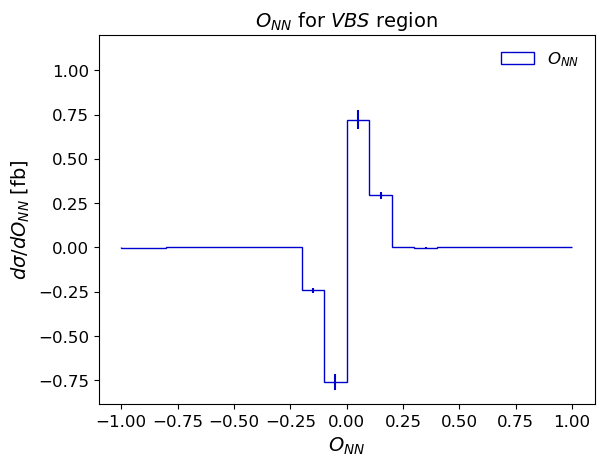

O_NN Fractional Uncertainty: [-3.16232157e-01 -5.25677696e-01 -7.07106767e-01  0.00000000e+00
  4.83846595e+02 -7.07106787e-01  0.00000000e+00  2.35883707e+00
 -6.54258772e-02 -6.27340929e-02  7.37645478e-02  6.37972019e-02
  5.00010120e-01 -5.00000270e-01  5.00000023e-01 -1.91352201e+02
  7.07106794e-01  5.00002251e-01  0.00000000e+00  5.00000001e-01]


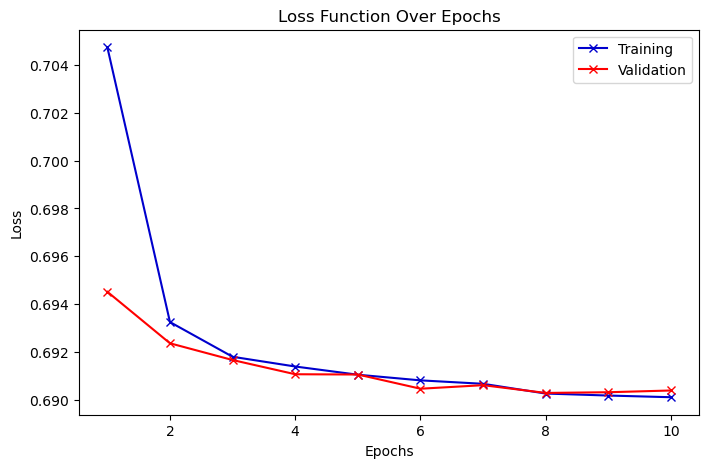

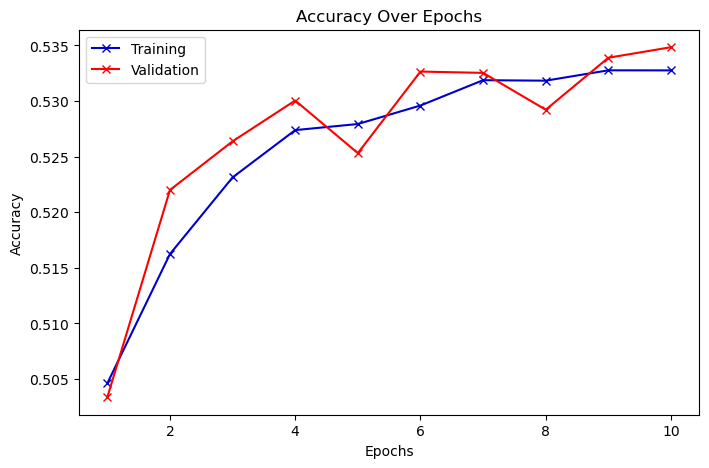

In [9]:
def __main__():
    vbs_data = DataLoader("VBS_data_cwtil_2.feather", ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi'])
    model_filename = "vbs_l_eta_phi.keras"

    param_grid = {
            'learning_rate': [0.001, 0.01],
            'neurons': [16, 32, 64],
            'layers': [2, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        vbs_model = MLModel()
        vbs_model.grid_search(vbs_data.x_data, vbs_data.y_data, param_grid, model_filename)
    
    vbs_model, vbs_history = MLModel.load_ML_model(model_filename)

    vbs_results = vbs_model.predict(vbs_data.x_data)
    Plotter.plot_ML_observable(vbs_results, vbs_data.weight_data, "VBS", 2)
    Plotter.plot_loss(vbs_history)
    Plotter.plot_accuracy(vbs_history)

if __name__ == '__main__':
    __main__()

x_data, y_data, weight_data (169076, 24) (169076, 1) (169076, 1)
No existing model found, training new model
Fitting 2 folds for each of 72 candidates, totalling 144 fits

Running fit 1/144

Running fit 1/144

Running fit 1/144

Running fit 1/144

Running fit 1/144

Running fit 1/144

Running fit 1/144

Running fit 1/144
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  21.8s

Running fit 1/144
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=  24.6s

Running fit 1/144
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=  32.0s

Running fit 1/144
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  41.9s

Running fit 1/144
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, 

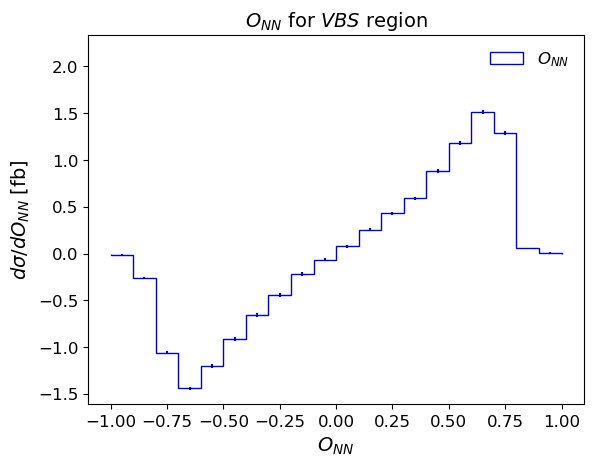

O_NN Fractional Uncertainty: [-0.12304869 -0.03028324 -0.01584189 -0.01452295 -0.01715098 -0.02182117
 -0.02920298 -0.04001988 -0.07859955 -0.25422675  0.22231013  0.06616438
  0.04054526  0.02993697  0.02111726  0.01765168  0.0143805   0.01460034
  0.06900475  0.17695432]


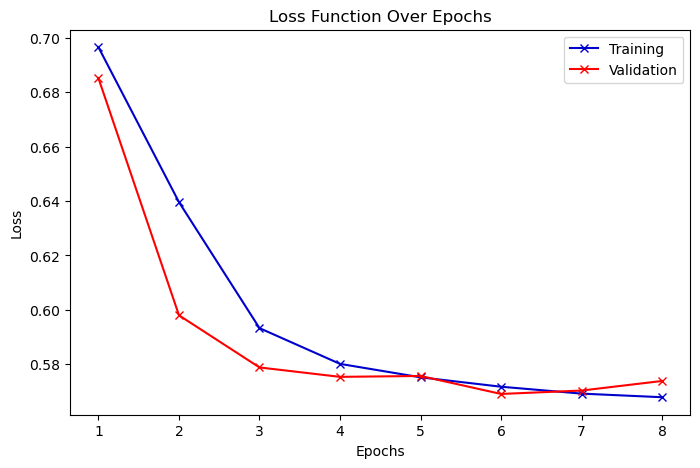

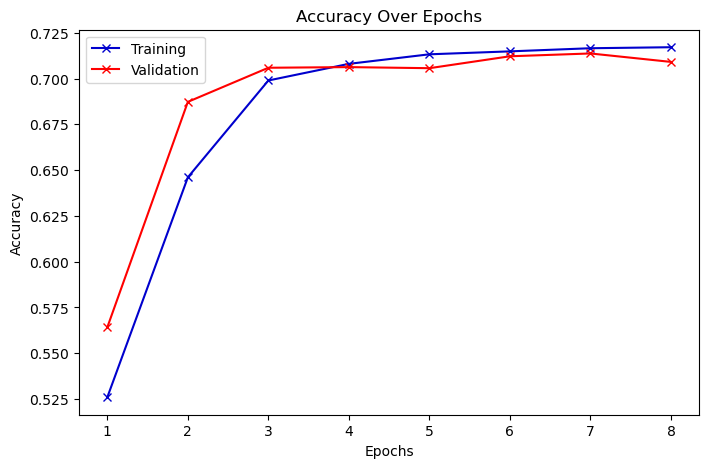

In [11]:
def __main__():
    vbs_data = DataLoader("VBS_data_cwtil_2.feather", ['Jet.Eta', 'Jet.Phi'])
    model_filename = "vbs_j_eta_phi.keras"

    param_grid = {
            'learning_rate': [0.001, 0.01],
            'neurons': [16, 32, 64],
            'layers': [2, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        vbs_model = MLModel()
        vbs_model.grid_search(vbs_data.x_data, vbs_data.y_data, param_grid, model_filename)
    
    vbs_model, vbs_history = MLModel.load_ML_model(model_filename)

    vbs_results = vbs_model.predict(vbs_data.x_data)
    Plotter.plot_ML_observable(vbs_results, vbs_data.weight_data, "VBS", 2)
    Plotter.plot_loss(vbs_history)
    Plotter.plot_accuracy(vbs_history)

if __name__ == '__main__':
    __main__()

x_data, y_data, weight_data (69132, 66) (69132, 1) (69132, 1)
No existing model found, training new model
Fitting 2 folds for each of 96 candidates, totalling 192 fits

Running fit 1/192

Running fit 1/192

Running fit 1/192

Running fit 1/192

Running fit 1/192

Running fit 1/192

Running fit 1/192
Running fit 1/192

[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=  14.3s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  15.2s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  17.6s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.001; total time=  19.0s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001,

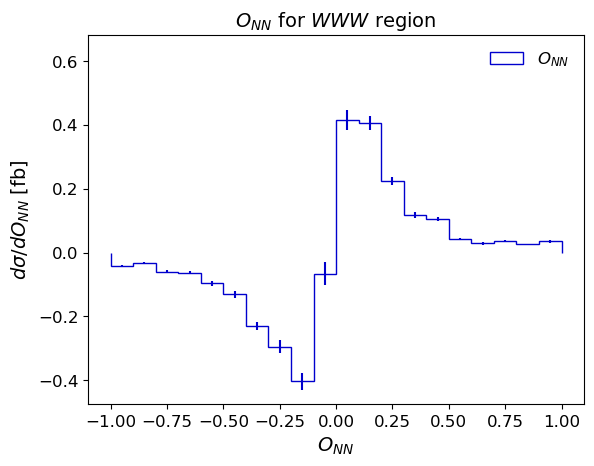

O_NN Fractional Uncertainty: [-0.08393689 -0.09885807 -0.09286793 -0.08549633 -0.07381705 -0.07519767
 -0.05461427 -0.06798979 -0.06937245 -0.55909239  0.07569763  0.0526883
  0.06250818  0.07669665  0.06732793  0.10673343  0.12815199  0.09525586
  0.10861968  0.11979907]


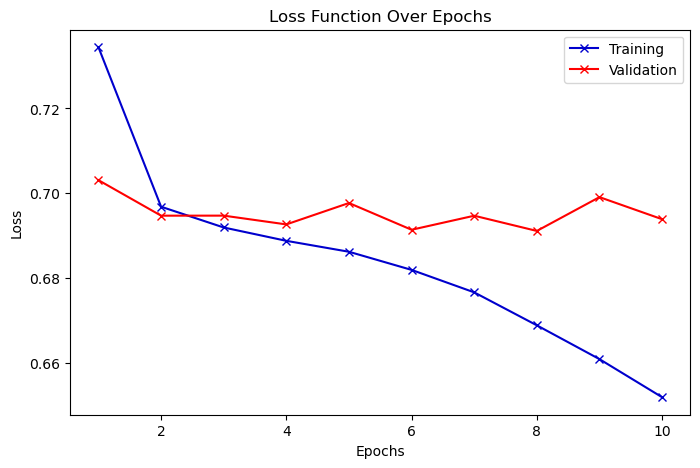

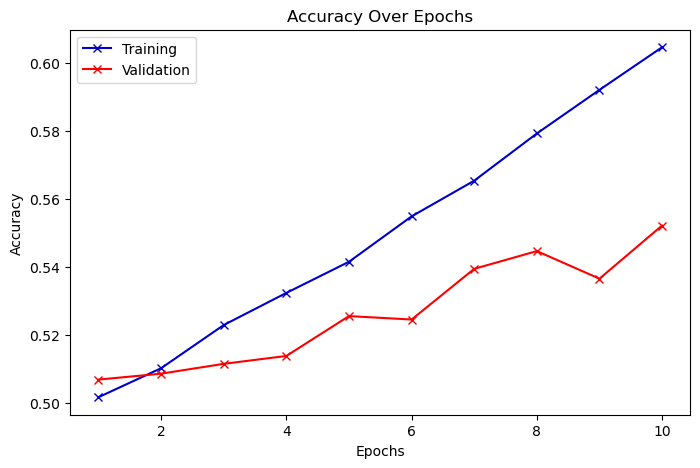

In [12]:
def __main__():
    www_data = DataLoader("WWW_data_cwtil_large_1.feather", ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi', 'Jet.Eta', 'Jet.Phi'])
    model_filename = "www_lj_eta_phi.keras"

    param_grid = {
            'learning_rate': [0.001, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        www_model = MLModel()
        www_model.grid_search(www_data.x_data, www_data.y_data, param_grid, model_filename)
    
    www_model, www_history = MLModel.load_ML_model(model_filename)

    www_results = www_model.predict(www_data.x_data)
    Plotter.plot_ML_observable(www_results, www_data.weight_data, "WWW", 2)
    Plotter.plot_loss(www_history)
    Plotter.plot_accuracy(www_history)

if __name__ == '__main__':
    __main__()

x_data, y_data, weight_data (69132, 44) (69132, 1) (69132, 1)
No existing model found, training new model
Fitting 2 folds for each of 96 candidates, totalling 192 fits

Running fit 1/192

Running fit 1/192

Running fit 1/192

Running fit 1/192

Running fit 1/192

Running fit 1/192

Running fit 1/192

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  16.5s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  18.0s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  18.1s

Running fit 1/192

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=  19.2s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001

/home/finfullerton/mambaforge/envs/mphys/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END batch_size=128, dropout_rate=0.2, layers=4, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  31.6s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0.2, layers=4, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.001; total time=  26.3s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0.2, layers=4, learning_rate=0.001, neurons=32, patience=2, reg_strength=0.0001; total time=  23.9s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0.2, layers=4, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  26.7s

Running fit 1/192

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0.2, layers=4, learning_rate=0.001, neurons=32, patience=2, reg_strength=0.001; total time=  27.0s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0.2, layers=4, learning_rate=0.001, neurons=32, patience=2, reg_strength=0.0001; total time=  33.1s

Running fit 1/192
[CV] END batch_size=128, dropout_rate=0.2, lay

/tmp/ipykernel_1030/35756868.py:178: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)


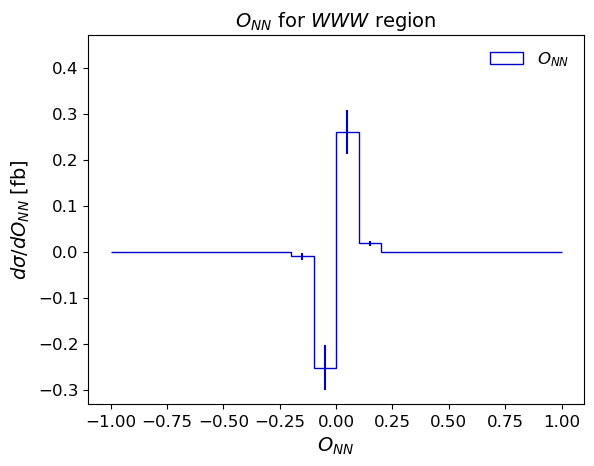

O_NN Fractional Uncertainty: [ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.79974815 -0.19634399  0.18084562  0.31688793
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


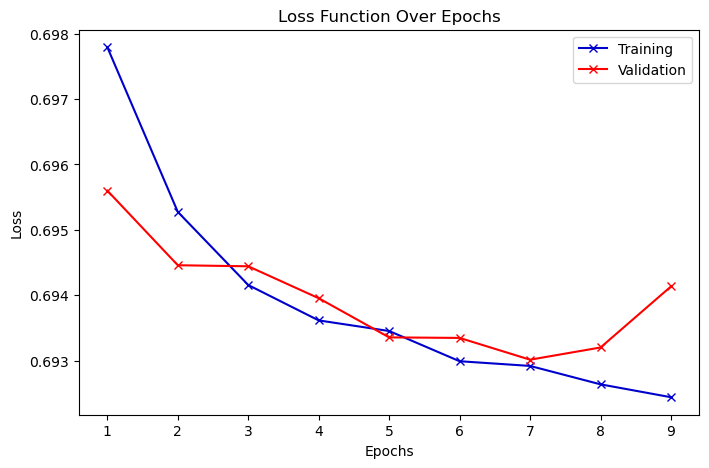

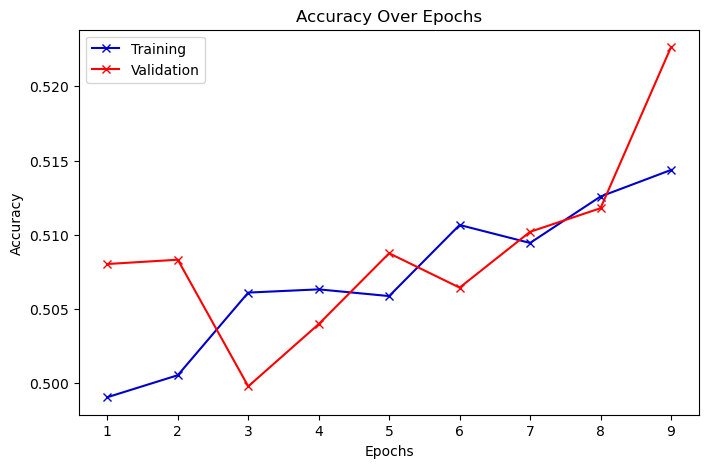

In [13]:
def __main__():
    www_data = DataLoader("WWW_data_cwtil_large_1.feather", ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi'])
    model_filename = "www_l_eta_phi.keras"

    param_grid = {
            'learning_rate': [0.001, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        www_model = MLModel()
        www_model.grid_search(www_data.x_data, www_data.y_data, param_grid, model_filename)
    
    www_model, www_history = MLModel.load_ML_model(model_filename)

    www_results = www_model.predict(www_data.x_data)
    Plotter.plot_ML_observable(www_results, www_data.weight_data, "WWW", 2)
    Plotter.plot_loss(www_history)
    Plotter.plot_accuracy(www_history)

if __name__ == '__main__':
    __main__()

x_data, y_data, weight_data (69132, 22) (69132, 1) (69132, 1)
No existing model found, training new model
Fitting 2 folds for each of 96 candidates, totalling 192 fits
Best Accuracy: 0.5162 using {'batch_size': 128, 'dropout_rate': 0, 'layers': 4, 'learning_rate': 0.001, 'neurons': 32, 'patience': 2, 'reg_strength': 0.001}
{'accuracy': [0.5050356984138489, 0.5101166367530823, 0.5114365816116333, 0.5157761573791504, 0.5221408605575562, 0.5249254107475281, 0.5287044644355774, 0.5306029915809631, 0.5324292778968811, 0.5371123552322388], 'loss': [0.7134068608283997, 0.7014902234077454, 0.6971654295921326, 0.6945172548294067, 0.6925638914108276, 0.691228449344635, 0.6897991299629211, 0.6888662576675415, 0.6877027750015259, 0.6861995458602905], 'val_accuracy': [0.5035440325737, 0.5135252475738525, 0.49761319160461426, 0.5142484903335571, 0.5206133127212524, 0.5214812755584717, 0.5191667675971985, 0.518298864364624, 0.5142484903335571, 0.5245190262794495], 'val_loss': [0.7056087255477905, 0.6

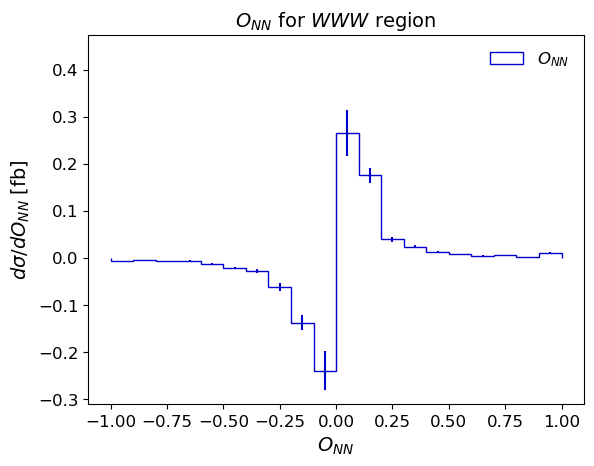

O_NN Fractional Uncertainty: [-0.20038152 -0.27914288 -0.20692156 -0.22169743 -0.15999561 -0.1228794
 -0.16527441 -0.13570012 -0.11629851 -0.17515724  0.18136781  0.09173153
  0.13397216  0.12767718  0.17647745  0.22314449  0.70803609  0.23570385
  0.57644839  0.26326047]


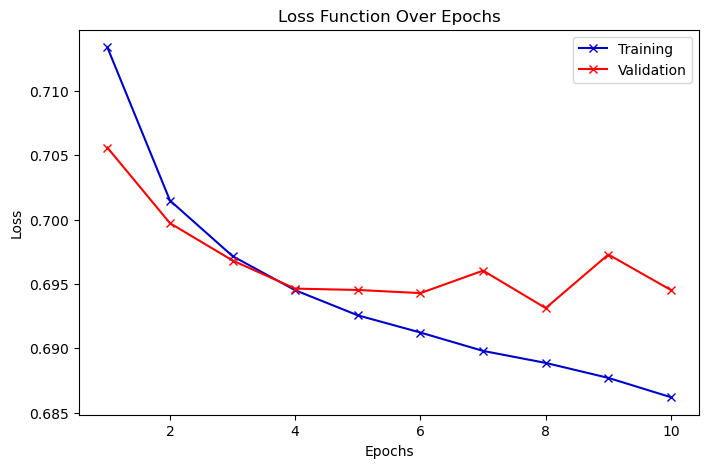

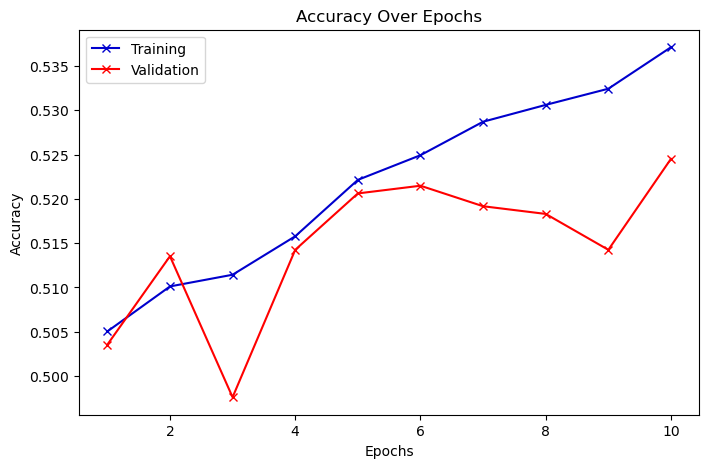

In [4]:
def __main__():
    www_data = DataLoader("WWW_data_cwtil_large_1.feather", ['Jet.Eta', 'Jet.Phi'])
    model_filename = "www_j_eta_phi.keras"

    param_grid = {
            'learning_rate': [0.001, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        www_model = MLModel()
        www_model.grid_search(www_data.x_data, www_data.y_data, param_grid, model_filename)
    
    www_model, www_history = MLModel.load_ML_model(model_filename)

    www_results = www_model.predict(www_data.x_data)
    Plotter.plot_ML_observable(www_results, www_data.weight_data, "WWW", 2)
    Plotter.plot_loss(www_history)
    Plotter.plot_accuracy(www_history)

if __name__ == '__main__':
    __main__()